In [1]:
# algebra and dataframes
import numpy as np
import pandas as pd

# text processing
import re
import spacy
from gensim.models.phrases import Phrases, Phraser
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


# hypothesis testing
from scipy.stats import gamma, kstest, lognorm, mannwhitneyu, ks_2samp
from scipy.sparse import hstack, vstack

# charts
import matplotlib.pyplot as plt
import seaborn as sns

# data processing
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer, LabelEncoder, StandardScaler, \
RobustScaler, OneHotEncoder, MaxAbsScaler
from sklearn.pipeline import make_pipeline, make_union, FeatureUnion
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import category_encoders as ce
from xgboost import XGBRegressor

# measurement metrics
from sklearn.metrics import classification_report, make_scorer, mean_squared_error, mean_squared_log_error

# charting paramemters
from pylab import rcParams
rcParams.update({'font.size' : 14, 'legend.fontsize' : "small", 
                 "xtick.labelsize" : 14, "ytick.labelsize" : 14, 
                 "figure.figsize":(9, 6), "axes.titlesize" : 20,
                 "axes.labelsize" : 14, "lines.linewidth" : 3, 
                 "lines.markersize" : 10
                })

from sklearn.linear_model import Ridge

In [2]:
data = pd.read_table('../data/train.tsv')
test = pd.read_table('../data/test.tsv')

In [42]:
seed = 20
quick = True

if quick:
    data = data.sample(frac=.1, random_state = seed)

In [33]:
def get_match(text):
     
        try:
            return re.search(r"\w+([^a-zA-Z0-9' &.-_®+-])\w+", text).group(0) 
        
        except: 
            return

In [30]:
re.search(r"\w+([^a-zA-Z0-9' &.-_®+-])\w+", 'blarb us Aéropostale is ok').group(0)

'Aéropostale'

In [34]:
result = data.brand_name.apply(get_match)

In [37]:
result.value_counts()

Aéropostale    408
A|X            294
dELiA*s        158
Stüssy          64
L*SPACE         37
Hermès          23
Céline          16
Lancôme         16
Bésame           3
Estée            2
Earth’s          1
Frédérique       1
L’Occitane       1
Name: brand_name, dtype: int64

In [67]:
data.loc[1106558]

train_id                                                       1106558
name                                        Aeropostale Floral Dresses
item_condition_id                                                    2
category_name                           Women/Dresses/Above Knee, Mini
brand_name                                                 Aéropostale
price                                                               11
shipping                                                             0
item_description     2 floral Aeropostale crossed back dresses, one...
cat1                                                             Women
cat2                                                           Dresses
cat3                                                  Above Knee, Mini
Name: 1106558, dtype: object

In [20]:
data.isnull().sum()

train_id                 0
name                     0
item_condition_id        0
category_name          666
brand_name           63293
price                    0
shipping                 0
item_description         0
cat1                     0
cat2                     0
cat3                     0
dtype: int64

In [8]:
data.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1065093,1065093,Kylie Metal Matte Kymajesty,1,Beauty/Makeup/Lips,NaN,18.0,1,Brand new in box - Never Swatched! Kylie's exo...
407370,407370,Joggers camouflage,2,Kids/Boys (4+)/Bottoms,Arizona,9.0,0,Camouflage jogger pants never worn at all boy'...
688213,688213,LuLaRoe Cassie & Irma Bundle - XL/Medium,1,"Women/Skirts/Straight, Pencil",LuLaRoe,54.0,1,This gorgeous Cassie has a solid black backgro...
155188,155188,Cute Sequins Top,3,Women/Tops & Blouses/Blouse,Maurices,6.0,1,Excellent condition except a lil highlighter m...
1309673,1309673,NEW NYX eyeshadow palette avant pop,1,Beauty/Makeup/Makeup Palettes,NYX,10.0,1,Brand new and sealed NYX eyeshadow palette in ...
565424,565424,Deadrising 3 and a 3 day Xbox live card,3,Vintage & Collectibles/Electronics/Video Game,Xbox,14.0,0,It's in a pretty good condition and used but w...
1043925,1043925,FULL ZIP HOODIE,1,Women/Sweaters/Full Zip,PINK,49.0,0,BRAND NEW VS PINK FULL ZIP HOODIE PRICE IS FIRM
1309082,1309082,9months boy,3,Kids/Boys 0-24 Mos/One-Pieces,Carter's,21.0,0,Baby boy 9m cloths . No stains
966563,966563,Black Nike pro spandex shorts size XL,1,Women/Athletic Apparel/Shorts,Nike,24.0,0,Brand new with tags Black Nike pro spandex sho...
1428151,1428151,Rae Dunn Faith Mug And Blessed Bowl,1,Home/Kitchen & Dining/Coffee & Tea Accessories,Rae Dunn,26.0,0,Rae Dunn Faith mug Blessed bowl bundle


In [9]:
tbl_price = data.groupby(['item_condition_id', 'shipping'])['price'].agg([np.mean, np.median, len])
tbl_price

mean  median      len
item_condition_id shipping                            
1                 0         32.744244    23.0  28101.0
                  1         21.445607    14.0  35924.0
2                 0         29.063278    19.0  23294.0
                  1         23.734701    15.0  14282.0
3                 0         27.993743    18.0  28287.0
                  1         24.061085    15.0  14881.0
4                 0         27.108725    16.0   2235.0
                  1         20.142433    12.0   1011.0
5                 0         33.615894    21.0    151.0
                  1         31.113636    15.0     88.0

In [15]:
data[data.category_name=='Women/Athletic Apparel/Pants, Tights, Leggings'].groupby('item_condition_id')['price'].count()

item_condition_id
1    3095
2    1449
3    1312
4      61
5       1
Name: price, dtype: int64

In [16]:
data[data.category_name=='Women/Athletic Apparel/Pants, Tights, Leggings'].groupby('item_condition_id')['price'].agg([np.mean, np.median, len])

,mean,median,len
item_condition_id,,,
1,38.654766,35.0,3095.0
2,30.806073,25.0,1449.0
3,26.676067,20.0,1312.0
4,19.721311,14.0,61.0
5,4.000000,4.0,1.0


In [19]:
print(len(data.brand_name.str.lower().value_counts().index.values))
len(set(data.brand_name.str.lower().value_counts().index.values))

2369


2369

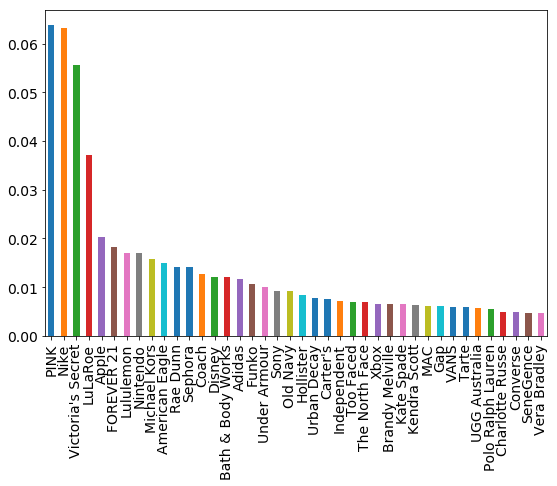

In [11]:
data.brand_name.value_counts(normalize = True)[0:40].plot(kind = 'bar')

In [11]:
def count_len(cell):
    try: 
        if np.isnan(cell):
            return 0
    except:
        return len(cell)

In [12]:
data['desc_lengths'] = [count_len(item) for item in data.item_description]

In [15]:
# translate should be fastest punctuation replacement
import string

s = data.item_description.iloc[55]+'!'
translator = str.maketrans('', '', string.punctuation)
s.translate(translator)

'Very durable and comfortable New'

In [16]:
translator = str.maketrans('', '', string.punctuation)

In [17]:
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1065093,1065093,Kylie Metal Matte Kymajesty,1,Beauty/Makeup/Lips,NaN,18.0,1,Brand new in box - Never Swatched! Kylie's exo...
407370,407370,Joggers camouflage,2,Kids/Boys (4+)/Bottoms,Arizona,9.0,0,Camouflage jogger pants never worn at all boy'...
688213,688213,LuLaRoe Cassie & Irma Bundle - XL/Medium,1,"Women/Skirts/Straight, Pencil",LuLaRoe,54.0,1,This gorgeous Cassie has a solid black backgro...
155188,155188,Cute Sequins Top,3,Women/Tops & Blouses/Blouse,Maurices,6.0,1,Excellent condition except a lil highlighter m...
1309673,1309673,NEW NYX eyeshadow palette avant pop,1,Beauty/Makeup/Makeup Palettes,NYX,10.0,1,Brand new and sealed NYX eyeshadow palette in ...


## Text prep

In [53]:
clean_text(['a baboon comes here everyday is not the one for there were no chickens'])

[['baboon', 'come', 'everyday', 'chicken']]

In [63]:
from textblob import Word

nlp = spacy.load('en', disable = ['parser', 'ner'])

def regex_replace(texts, substitute = '', regex_pattern = r"[^a-zA-z' ]|'s" ):
    
    pattern = re.compile(regex_pattern)
    
    result = []
    for text in texts:
        replaced = pattern.sub(substitute, text)
        replaced = replaced.replace(r"\n", '').replace('  ', ' ').lower().strip()
        result.append(replaced)
    
    return result

def join_not(text):
    replace_these = re.findall(r'not\s+\w+', text)
    for item in replace_these:
        tmp = item.replace(' ', '_')
        text = text.replace(item, tmp)

    return text

def reg_replace(text):
        # remove HTML
    # text = BeautifulSoup(text, "html.parser").get_text()
    
    #removes remaining urls
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
       
    # removes numbers, symbols, nextline symbols 
    text = re.sub(r"[^a-zA-Z' ]"," ", text)   
    text = text.replace(r"\n", '').replace('  ', ' ').lower().strip('.')
    
    # removes some possessive, needs improvement
    text = re.sub(r"'s", "", text)

    return text

                
def clean_text(texts, removals = {"x", "s", "v", "'s"}):
    
    texts = nlp.pipe(texts, batch_size = 1000)
    
    
    # removes punctuation and pronouns, random words, normalizes words by lemmatization
    word_lists=[]
    for sent in texts:
        words = []
        for word in sent:
            if (not word.is_punct and word.pos_ != 'PRON') and \
            not (word.pos_ == 'DET'  or word.is_stop):
                lemma = word.lemma_
                if lemma not in removals:
                    words.append(lemma)
        word_lists.append(words)
                
    return word_lists

def clean_text2(texts):
    
    texts = nlp.pipe(texts, batch_size = 1000)
    removals = {"x", "s", "v", "'s"}
    
    # removes punctuation and pronouns, random words, normalizes words by lemmatization
    word_lists=[]
    for sent in texts:
        words = []
        for word in sent:
            if (not word.is_punct and word.pos_ != 'PRON') and \
            not (word.pos_ == 'DET'  and word.is_stop):
                if word not in removals:
                    words.append(Word(word.text).lemmatize('v'))
        word_lists.append(words)
                
    return word_lists

def blob_lemmatize(text):
    
    text = TextBlob(text)
    word_list = []
    for word in text.words:
        word_list.append(word.lemmatize('v'))
    return word_list

def remove_stops(unigrams, removals=['not'], join = False):
    
    # removes item from set
    if len(removals) > 0:
        for item in removals:
            try:
                spacy.lang.en.STOP_WORDS.remove(item)
            except Exception as error:
                #print(error)
                pass
    
    unigrams = [word for word in unigrams if word not in spacy.lang.en.STOP_WORDS]
    
    if join:
        return ' '.join(unigrams)
    else:
        return unigrams

In [64]:
from spacy import displacy

test = 'The ball was never there in the first place, how many chickens would we eat before the end of the day?'
test = nlp(test)
displacy.render(test,style='dep', jupyter = True)

/home/ryeyoo/anaconda3/lib/python3.6/runpy.py:193: UserWarning: [W005] Doc object not parsed. This means displaCy won't be able to generate a dependency visualization for it. Make sure the Doc was processed with a model that supports dependency parsing, and not just a language class like `English()`. For more info, see the docs:
https://spacy.io/usage/models
  "__main__", mod_spec)


In [68]:
print(nlp.pipe_names)
test = nlp(data.item_description.iloc[5], disable = ['tagger', 'parser', 'ner'])
for token in test:
    print(token.orth_, token.pos_, 'lemma:', token.lemma_, 'tag:', token.tag_, 'stopword?:', token.is_stop, 'punctuation?:', token.is_punct, token.text)
    


['tagger', 'parser', 'ner', 'entity_matcher']
Banana  lemma: Banana tag:  stopword?: False punctuation?: False Banana
republic  lemma: republic tag:  stopword?: False punctuation?: False republic
bottoms  lemma: bottom tag:  stopword?: False punctuation?: False bottoms
,  lemma: , tag:  stopword?: False punctuation?: True ,
Candies  lemma: Candies tag:  stopword?: False punctuation?: False Candies
skirt  lemma: skirt tag:  stopword?: False punctuation?: False skirt
with  lemma: with tag:  stopword?: True punctuation?: False with
matching  lemma: match tag:  stopword?: False punctuation?: False matching
blazer  lemma: blazer tag:  stopword?: False punctuation?: False blazer
,  lemma: , tag:  stopword?: False punctuation?: True ,
Amy  lemma: Amy tag:  stopword?: False punctuation?: False Amy
Byers  lemma: Byers tag:  stopword?: False punctuation?: False Byers
suit  lemma: suit tag:  stopword?: False punctuation?: False suit
,  lemma: , tag:  stopword?: False punctuation?: True ,
Loft  le

In [69]:
for ent in test.ents:
    print(ent)

In [55]:
data.isnull().sum()/data.shape[0]

train_id             0.000000
name                 0.000000
item_condition_id    0.000000
category_name        0.004268
brand_name           0.426757
price                0.000000
shipping             0.000000
item_description     0.000003
dtype: float64

In [66]:
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

class EntityMatcher(object):
    name = 'entity_matcher'

    def __init__(self, nlp, terms, label):
        patterns = [nlp(text) for text in terms]
        self.matcher = PhraseMatcher(nlp.vocab)
        self.matcher.add(label, None, *patterns)

    def __call__(self, doc):
        matches = self.matcher(doc)
        for match_id, start, end in matches:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]
        return doc

nlp = spacy.load('en_core_web_sm')
terms = (u'cat', u'dog', u'tree kangaroo', u'giant sea spider')
entity_matcher = EntityMatcher(nlp, terms, 'ANIMAL')

nlp.add_pipe(entity_matcher, after='ner')
print(nlp.pipe_names)  # the components in the pipeline

doc = nlp(u"This is a text about Barack Obama and a tree kangaroo")
print([(ent.text, ent.label_) for ent in doc.ents])

['tagger', 'parser', 'ner', 'entity_matcher']
[('Barack Obama', 'PERSON'), ('tree kangaroo', 'ANIMAL')]


In [80]:
vectorizer.fit_transform([' '.join(item) for item in parsed_names])

<148254x4635 sparse matrix of type '<class 'numpy.int64'>'
	with 556096 stored elements in Compressed Sparse Row format>

In [82]:
data['parsed_names'] = [' '.join(item) for item in parsed_names]

In [38]:
from collections import Counter
Counter(parsed_names).most_common(200)

NameError: name 'parsed_names' is not defined

In [44]:
def combine_names(brand, name):
    if brand in name:
        return name
    else:
        return brand + ' ' + name

In [45]:
%%time
# combining names and brand
combined_names = np.vectorize(combine_names)(data.brand_name.fillna(''), data.name.fillna('')) 
parsed_names = regex_replace(combined_names)
parsed_names = clean_text(parsed_names)

CPU times: user 18.4 s, sys: 27.7 ms, total: 18.5 s
Wall time: 18.5 s


In [48]:
parsed_names = [' '.join(item) for item in parsed_names]

In [50]:
parsed_names[0:10]

['kylie metal matte kymajesty',
 'arizona jogger camouflage',
 'lularoe cassie irma bundle xlmedium',
 'maurices cute sequin',
 'new nyx eyeshadow palette avant pop',
 'deadrising day xbox live card',
 'pink zip hoodie',
 'carter month boy',
 'black nike pro spandex short size xl',
 'rae dunn faith mug bless bowl']

In [37]:
parsed_names[0:10]

['kylie metal matte kymajesty',
 'arizona joggers camouflage',
 'lularoe lularoe cassie irma bundle xlmedium',
 'maurices cute sequins top',
 'nyx new nyx eyeshadow palette avant pop',
 'xbox deadrising and a day xbox live card',
 'pink full zip hoodie',
 'carter months boy',
 'nike black nike pro spandex shorts size xl',
 'rae dunn rae dunn faith mug and blessed bowl']

In [52]:
combined_names

1065093                                                  NaN
407370                             Joggers camouflageArizona
688213       LuLaRoe Cassie & Irma Bundle - XL/MediumLuLaRoe
155188                              Cute Sequins TopMaurices
1309673               NEW NYX eyeshadow palette avant popNYX
565424           Deadrising 3 and a 3 day Xbox live cardXbox
1043925                                  FULL ZIP HOODIEPINK
1309082                                  9months boyCarter's
966563             Black Nike pro spandex shorts size XLNike
1428151          Rae Dunn Faith Mug And Blessed BowlRae Dunn
68447                                                    NaN
91265                                   Fenty Flip FlopsPUMA
77999                                                    NaN
975978                                                   NaN
1066167        2PC (L) NWOT VS PINK APPARELVictoria's Secret
524248            Funko Pop! Jimi Hendrix FYE ExclusiveFunko
1151062                 

In [56]:
%%time
# combining names + brand
combined_names = data.name + data.brand_name
parsed_names = regex_replace(combined_names.fillna(''))

combined_text = data.item_description.fillna('unknown') + data.category_name.fillna('unknown') + data.brand_name.fillna('unknown') + data.name.fillna('unknown')
desc_list = regex_replace(combined_text)
parsed_text = clean_text(desc_list)

CPU times: user 1min 16s, sys: 87.3 ms, total: 1min 16s
Wall time: 1min 16s


In [59]:
parsed_text[5]

['pretty',
 'good',
 'condition',
 'work',
 'xbox',
 'onevintage',
 'collectibleselectronicsvideo',
 'gamexboxdeadrising',
 'day',
 'xbox',
 'live',
 'card']

In [113]:
%%time
#desc_list = regex_replace(data.item_description)
item_descriptions = clean_text2(desc_list)

CPU times: user 20min 54s, sys: 32min 14s, total: 53min 8s
Wall time: 5min 1s


In [177]:
%%time
phrase_model = Phraser(Phrases(parsed_text))
parsed_bigrams = [' '.join(phrase_model[item_descriptions[i]]) for i in range(0,len(item_descriptions))]
description_matrix = vectorizer.fit_transform(parsed_bigrams)

CPU times: user 22.7 s, sys: 64 ms, total: 22.8 s
Wall time: 22.8 s


In [95]:
%%time
seed = 20
nmf = NMF(n_components = 20, random_state = seed)
#description_W = nmf.fit_transform(description_matrix)

svd = TruncatedSVD(n_components = 20, random_state = seed)
#description_svd = svd.fit_transform(description_matrix)

#vectorizer = TfidfVectorizer( max_df = 0.99, min_df = 10, stop_words = 'english')
vectorizer = CountVectorizer( max_df = 0.99, min_df = 10)
vectorizer2 = TfidfVectorizer(max_df = 0.2, min_df = 10, stop_words = 'english')

lda = LatentDirichletAllocation(n_components = 20, n_jobs = 4, random_state = seed)

CPU times: user 72 µs, sys: 0 ns, total: 72 µs
Wall time: 79.6 µs


In [10]:
%%time
tdm = vectorizer.fit_transform(data.item_description)
result = lda.fit_transform(tdm)

/home/ryeyoo/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


CPU times: user 5min 44s, sys: 37.5 ms, total: 5min 44s
Wall time: 5min 44s


# Pipes

In [ ]:
func = make_pipeline(FunctionTransformer(func = column_select, validate = False), vectorizer)

In [161]:
Pipeline([('vec', vectorizer), ('nmf', nmf)])

Pipeline(memory=None,
     steps=[('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=10,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...iter=200,
  n_components=20, random_state=20, shuffle=False, solver='cd', tol=0.0001,
  verbose=0))])

In [168]:
# method1
pipe1 = FeatureUnion(transformer_list = 
    [ 
        
    ('nmf_pipe', Pipeline([('vec', vectorizer), ('nmf', nmf)])),
    ('svd_pipe', Pipeline([('vec', vectorizer), ('svd', svd)]))
    
    ])

In [181]:
data['parsed_descriptions'] = parsed_bigrams
cols = [item for item in data.columns.values if item not in ['price', 'names', 'train_id']]

## Custom Classes

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

# from sklearn's tutorial
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
    
class categorical_means(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return None
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None, col_name = 'category_name', response_var = 'price'):
#         stuff = cat_means(X)
        return self.cat_means(X, col_name, response_var)
#         return stuff
    
    def tmp(self, data):
        return data
    
    def cat_means(self, data, col_name, response_var):
    
        grouped_data = data.groupby(col_name)[response_var].agg([len, np.mean, np.median])
        conversion_dict = {name:mean for name, mean in zip(grouped_data[grouped_data.len > 30].index, 
                                                       grouped_data[grouped_data.len > 30]['mean'])}
        converted = [conversion_dict[name] if name in conversion_dict else -1 for name in data[col_name]]

        return converted

In [6]:
def split_cats(data):
    
    cat_splits = data.category_name.str.split('/')
    cat1 = []
    cat2 = []
    cat3 = []
    for item in cat_splits:
        if item is np.nan:
            cat1.append('none')
            cat2.append('none')
            cat3.append('none')
        else:
            cat1.append(item[0])
            cat2.append(item[1])
            cat3.append(item[2])
    data['cat1'] = cat1
    data['cat2'] = cat2
    data['cat3'] = cat3
   
    return data

data = split_cats(data)

In [8]:
pipe = make_pipeline(ItemSelector(['category_name', 'brand_name', 'cat1', 'cat2', 'cat3']), 
                                                ce.target_encoder.TargetEncoder(return_df = False, 
                                                                                min_samples_leaf = 5))

In [10]:
result = pipe.fit_transform(data, data.price)

In [14]:
data.category_name.head()

1065093               Beauty/Makeup/Lips
407370            Kids/Boys (4+)/Bottoms
688213     Women/Skirts/Straight, Pencil
155188       Women/Tops & Blouses/Blouse
1309673    Beauty/Makeup/Makeup Palettes
Name: category_name, dtype: object

In [15]:
data.groupby('cat1').price.mean()

cat1
Beauty                    19.722217
Electronics               34.360410
Handmade                  18.253073
Home                      24.858027
Kids                      20.709439
Men                       34.849873
Other                     20.836427
Sports & Outdoors         24.900994
Vintage & Collectibles    26.097081
Women                     28.776906
none                      25.213213
Name: price, dtype: float64

In [12]:
result

array([[18.42545332, 26.61118756, 19.72221685, 18.6996605 , 18.28669053],
       [16.3040293 , 13.58355092, 20.70943884, 26.98872679, 17.02835052],
       [23.91746032, 33.92621913, 28.77690629, 21.24118738, 23.91746032],
       ...,
       [17.21435794,  7.66666667, 34.36041029, 29.83746246, 17.21435794],
       [23.38135593, 17.00005905, 24.85802651, 29.2233945 , 23.38135593],
       [31.45905369, 26.61118756, 28.77690629, 26.56233105, 31.45905369]])

In [4]:
from sklearn.model_selection import cross_val_score
import time

def rmsle(y, pred_y):
    
    pred_y = np.fmax(pred_y, 0)
    rmsle = np.sqrt(np.mean(np.power(np.log1p(pred_y) - np.log1p(y),2)))
    return rmsle

def function(params = {'objective': 'reg:gamma'}):
    
    
    print(params)
    print('start time %s ' % time.ctime())
    
    latent_pipe = \
    make_pipeline(
                    ItemSelector('item_description'), vectorizer, 
                        FeatureUnion( transformer_list = 
                                    [ 
                                        ('nmf_pipe',  nmf),
                                        ('svd_pipe',  svd)
                                    ]
                        )
                )

    
    feature_pipe = \
    FeatureUnion(transformer_list = \
            [ 
                ('nmf_svd', latent_pipe),
                ('shipping + condition', make_pipeline(ItemSelector(['shipping', 'item_condition_id']))),    
                ('target_encode', make_pipeline(ItemSelector(['category_name', 'brand_name', 'cat1', 'cat2', 'cat3']), 
                                                ce.target_encoder.TargetEncoder(return_df = False, 
                                                                                min_samples_leaf = 5)))

            ])

    final_pipe = make_pipeline(feature_pipe, StandardScaler(), XGBRegressor(**params))

    cv_score = cross_val_score(final_pipe, data, data['price'], cv = 5, scoring = make_scorer(rmsle))
    
    # displays time for optimization cycle purposes
    print('end time %s: ' % time.ctime())
    
    
    print(np.mean(cv_score))
    
    return np.mean(cv_score)

def function_log(regressor, params = {}, for_optimization = True):
    
    
    print(params)
    print('start time %s ' % time.ctime())
    
    latent_pipe = make_pipeline(
                        ItemSelector('item_description'), vectorizer, 
                                FeatureUnion(transformer_list = 
                                    [ 
                                        ('nmf_pipe',  nmf),
                                        ('svd_pipe',  svd),
                                        ('lda_pipe', lda)
                                    ]
                                    )
                                )
    name_pipe = make_pipeline(
                              ItemSelector('parsed_names'), CountVectorizer(min_df = 1),
                                FeatureUnion([
                                    ('lda', lda),
                                ])
                              )

    
    feature_pipe = FeatureUnion(transformer_list = 
                [ 
                    #('vectorizer', make_pipeline(ItemSelector('item_description'), vectorizer)),
                    ('nmf_svd', latent_pipe),
                    ('names', name_pipe),
                    ('shipping + condition', make_pipeline(ItemSelector(['shipping', 'item_condition_id']))),    
                    ('target_encode', make_pipeline(ItemSelector(['category_name', 'brand_name', 'cat1', 'cat2', 'cat3']), 
                                                    ce.target_encoder.TargetEncoder(return_df = False, 
                                                                                    min_samples_leaf = 3)))

                ])

    final_pipe = make_pipeline(feature_pipe, MaxAbsScaler(), regressor(**params))

    cv_score = cross_val_score(final_pipe, data, np.log1p(data['price']), cv = 5, scoring = 'neg_mean_squared_error')
    
    # displays time for optimization cycle purposes
    print('end time %s: ' % time.ctime())
    
    
    print (np.mean(np.sqrt(-cv_score)))
    
    if for_optimization:
        
        return np.mean(np.sqrt(-cv_score))
    
    else:
        
        return -cv_score
    

In [113]:
data.item_description = data.item_description.fillna('unknown')

In [100]:
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [101]:
%%time 
result = function_log(XGBRegressor, {'objective': 'reg:gamma', 'n_jobs':10}, False)

{'objective': 'reg:gamma', 'n_jobs': 10}
start time Thu Aug 23 14:34:22 2018 


/home/ryeyoo/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/ryeyoo/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/ryeyoo/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/ryeyoo/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online'

end time Thu Aug 23 16:48:16 2018: 
0.5685989428360386
CPU times: user 1h 16min 50s, sys: 8min 31s, total: 1h 25min 21s
Wall time: 2h 13min 53s


In [144]:
old_space = {
        'max_depth': hp.choice('max_depth', np.arange(10, 30, dtype=int)),
        'min_child_weight': hp.quniform ('min_child', 1, 20, 1),
        'subsample': hp.uniform ('subsample', 0.8, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(1000, 10000, 100, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.1, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
}

In [197]:
from hyperopt import fmin, tpe, hp

best = fmin(
    
    fn = function_log,
    
space = {
        'objective': 'reg:gamma',
        'n_estimators': hp.choice('n_estimators', np.arange(100, 300, 50)),
        'learning_rate': hp.quniform('learning_rate', 0.1, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'gamma': hp.quniform('gamma', 0, 1, 0.05),
        'n_jobs': 12,
        'random_state': 42
        },
    
    algo = tpe.suggest,
    max_evals = 10
           )



{'gamma': 0.05, 'learning_rate': 0.30000000000000004, 'max_depth': 9, 'min_child_weight': 5.0, 'n_estimators': 150, 'n_jobs': 12, 'objective': 'reg:gamma', 'random_state': 42}
start time Mon Aug 20 14:08:53 2018 
end time Mon Aug 20 14:21:54 2018: 
0.5722013447893856
{'gamma': 0.9, 'learning_rate': 0.35000000000000003, 'max_depth': 7, 'min_child_weight': 5.0, 'n_estimators': 100, 'n_jobs': 12, 'objective': 'reg:gamma', 'random_state': 42}
start time Mon Aug 20 14:21:54 2018 


KeyboardInterrupt: 

In [360]:
best

{'gamma': 0.30000000000000004,
 'learning_rate': 0.125,
 'max_depth': 6,
 'min_child_weight': 5.0,
 'n_estimators': 0}

In [143]:
space={
        'n_estimators': hp.choice('n_estimators', np.arange(100, 300, 50)),
        'learning_rate': hp.quniform('learning_rate', 0.1, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'gamma': hp.quniform('gamma', 0, 1, 0.05),
        'n_jobs': 12,
        'random_state': 42
    }


from hyperopt import space_eval
best_params = space_eval(space, best)

NameError: name 'best' is not defined

In [268]:
np.sqrt(np.mean(-cv_score))

35.875792741605146

In [241]:
np.sqrt(np.mean(-cv_score))

36.33422351942155

In [204]:
data.shape

(148254, 9)

In [125]:
pipe1.fit(parsed_bigrams)

FeatureUnion(n_jobs=12,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.99, max_features=None, min_df=10,
    ...runcatedSVD(algorithm='randomized', n_components=20, n_iter=5,
       random_state=20, tol=0.0))]))],
       transformer_weights=None)

In [176]:
ItemSelector('item_description').transform(data)

1065093    Brand new in box - Never Swatched! Kylie's exo...
407370     Camouflage jogger pants never worn at all boy'...
688213     This gorgeous Cassie has a solid black backgro...
155188     Excellent condition except a lil highlighter m...
1309673    Brand new and sealed NYX eyeshadow palette in ...
565424     It's in a pretty good condition and used but w...
1043925      BRAND NEW VS PINK FULL ZIP HOODIE PRICE IS FIRM
1309082                       Baby boy 9m cloths . No stains
966563     Brand new with tags Black Nike pro spandex sho...
1428151               Rae Dunn Faith mug Blessed bowl bundle
68447      Features: 100% Brand New. Material: Neoprene a...
91265      Fenty flip flop! Super cozy, awesome color! Co...
77999                                   Green Day band shirt
975978     From ipsy bag new never used never swatched it...
1066167    NWOT 2PC VS PINK V-NECK LS TEE AND PINK NATION...
524248     Funko Pop! Jimi Hendrix exclusive figure with ...
1151062    ☆PERFECT MOTH

In [126]:
result = pipe1.transform(parsed_bigrams)

In [129]:
result.shape

(148254, 40)

In [140]:
final_pipe = make_pipeline(pipe1, xgb.XGBRegressor())

In [7]:
from sklearn.pipeline import FeatureUnion, Pipeline

In [146]:
#make_union(make_pipeline(vectorizer, nmf), validate=False)
FeatureUnion([pipe1, xgb.XGBRegressor])

TypeError: zip argument #1 must support iteration

In [ ]:
description_svd.shape

In [ ]:
type(description_matrix)

In [ ]:
description_W.shape

In [ ]:
data.shape

In [ ]:
trn_idx, test_idx = train_test_split(range(len(data)), test_size = 0.3, random_state = seed)

## Custom classes

In [ ]:
cat = categorical_means()

In [ ]:
cat.transform(data, col_name = 'brand_name', response_var = 'price')

In [ ]:
make_pipeline(cat)

In [ ]:
data['category_means'] = cat_group_means(data)

In [ ]:

grouped_data = data.groupby('brand_name')['price'].agg([len, np.mean, np.median])

In [ ]:
cat_group_means(data, col_name = 'brand_name')

In [ ]:
data.shape

In [ ]:
data.head()

In [ ]:
pd.concat([pd.DataFrame(description_W), pd.DataFrame(description_svd), data.reset_index(drop=True)], axis = 1)

In [ ]:
pd.concat([pd.DataFrame(description_W), pd.DataFrame(description_svd), data.reset_index(drop=True)], axis = 1).to_csv('../processed/converted_array.csv')

In [ ]:
data.info()

In [ ]:
np.isnan('arg')

In [ ]:
clean_text(np.nan)

In [ ]:

data['cleaned_brands'] = [clean_text(item) for item in data.brand_name.fillna('unknown')]

In [ ]:
bigram_dict = {}
for item, score in phrases:
    bigram_dict[item] = score

In [ ]:
bigram_dict

## Entity recognition example

In [ ]:
doc = """The White House climb-down from President Donald Trump’s disastrous news conference with his Russian counterpart Vladimir Putin began Monday night, just hours after Trump said he saw “no reason” why Russia would have meddled in the 2016 election.

With even The Wall Street Journal’s editorial board — normally intensely loyal to Trump — joining in widespread criticism of the president’s implicit public rejection of U.S. intelligence claims, the White House circulated talking points to supporters saying that Trump still had great confidence in his intelligence agencies and that he believed their assessment that the Kremlin actively influenced the vote.

But the president himself emerged on Tuesday to personally walk back his statements in Helsinki, using a scheduled meeting with members of Congress to discuss tax reform as a platform for revising the statements that set off a 24-hour firestorm.

“In a key sentence in my remarks, I said the word ‘would’ instead of ‘wouldn’t,’” Trump said. “The sentence should have been — and I thought it would be maybe a little bit unclear on the transcript or unclear on the actual video — the sentence should have been: I don’t see any reason why it wouldn't be Russia. Sort of a double negative.”

"""

In [ ]:
doc = nlp(doc)

In [ ]:
for ent in doc.ents:
    print(ent.text, ent.label_)

In [ ]:
sns.distplot(data.desc_lengths)

In [ ]:
sns.distplot(sample)

In [ ]:
?lognorm

In [ ]:
# fit a gamma dist
fit_alpha, fit_loc, fit_beta=gamma.fit(data[data.category_name=='Women/Athletic Apparel/Pants, Tights, Leggings'].price)
print(fit_alpha, fit_loc, fit_beta)

In [ ]:
gamma.fit(list(data[data.category_name=='Women/Athletic Apparel/Pants, Tights, Leggings'].price))

In [ ]:
lognorm._fitstart(data[data.category_name=='Women/Athletic Apparel/Pants, Tights, Leggings'].price)

In [ ]:
lognorm.fit(data[data.category_name=='Women/Athletic Apparel/Pants, Tights, Leggings'].price)

In [ ]:
?lognorm.fit

In [ ]:
?kstest

In [ ]:
ks_2samp(np.array(data.price[data.brand_name.isnull()]), np.array(data.price[data.brand_name.notnull()]))

In [ ]:
# non-parametric indepedent samples
mannwhitneyu(data.price[data.brand_name.isnull()], 
                       data.price[data.brand_name.notnull()])

In [ ]:
sns.distplot(data[data.category_name=='Women/Athletic Apparel/Pants, Tights, Leggings'].price, bins = 100)
plt.xlim(0, 200)

In [ ]:
pd.pivot_table(data, values = 'price', index = 'brand_name', columns = 'shipping', aggfunc=(np.median, len)).columns

In [ ]:
# tuple to select multi-level index
pd.pivot_table(data, values = 'price', index = 'brand_name', columns = 'shipping', aggfunc=(np.median, len))[('len', 0)]

In [ ]:
brand_tbl = pd.pivot_table(data, values = 'price', index = 'brand_name', aggfunc=('mean', np.median, len), dropna=False).sort_values('len', ascending=False)
brand_tbl[brand_tbl.len > 30].sort_values('median', ascending=False)

In [ ]:
data.brand_name.isnull().sum()

In [ ]:
data.brand_name.value_counts(dropna=False, normalize=True)

In [ ]:
null_proportion = data.brand_name.value_counts(dropna=False, normalize=True)
1- data.brand_name.value_counts(dropna=False, normalize=True)[0]

In [ ]:
data['brand_name_null'] = data.brand_name.isnull()*1
sns.kdeplot(data.price[data.brand_name.notnull()])

In [ ]:


fig, ax = plt.subplots(sharex=True, sharey=True)

for data, label in zip([data.price[data.brand_name.isnull()], 
                       data.price[data.brand_name.notnull()]], 
                      ["0", "1"]):
     sns.kdeplot(data,  ax=ax, label = label, shade = True)
     #sns.distplot(data,  ax=ax, label = label)
   
#ax.set_xlim([-5, 250])

plt.show()

In [ ]:
data.price.describe()

In [ ]:
np.median(data.price)

In [ ]:
pd.pivot_table(data.fillna(-1), values = 'price', index = 'brand_name', aggfunc=(np.median, len), dropna=False).sort_values('len', ascending=False)

In [ ]:
# picks categorical columns, check for diff datasets
def get_categoricals(data):

    categorical_columns = []
    for dtype, idx in zip(data.dtypes, data.dtypes.index):
        if dtype == 'object':
            categorical_columns.append(idx)
    return categorical_columns

def encode_column(train_column, test_column, fillna = False):
    
    le = LabelEncoder()
    
    # le does not work with nan
    train_column = train_column.fillna('unknown')
    test_column = test_column.fillna('unknown')
    le.fit(train_column)
    train_column_le = le.transform(train_column)
    test_column_le = le.transform(test_column)
    translation_dict = {i:item for i, item in enumerate(le.classes_)}
    return train_column_le, test_column_le, translation_dict

# categorical to column arrays wide
def label_convert(train_column, test_column):
    
    encoder = LabelBinarizer()
    label_model = encoder.fit(train_column.fillna('unknown'))
    converted_train = label_model.transform(train_column.fillna('unknown'))
    converted_test = label_model.transform(test_column.fillna('unknown'))
    translation_dict = {i:item for i, item in enumerate(label_model.classes_)}
    return converted_train, converted_test, translation_dict

# keep cats in one column
def label_convert_cols(train, test):
    cols = get_categoricals(train)
    translation_dicts = {}
    train_column_stacks = []
    test_column_stacks = []
    for item in cols:
        train_column_labels, test_column_labels, translation_dict = encode_column(train[item], test[item])
        train_column_stacks.append(train_column_labels)
        test_column_stacks.append(test_column_labels)
        translation_dicts[item] = translation_dict
    train_arrays = np.vstack(train_column_stacks).T
    test_arrays = np.vstack(test_column_stacks).T
    return translation_dicts, train_arrays, test_arrays 

# converts all categorical columns into sparse format
def convert_columns(train, test, cols):
    
    translation_dicts = {}
    converted_train_arrays = []
    converted_test_arrays = []
    for column in cols:
        converted_train, converted_test, translation_dict = label_convert(train[column], test[column])
        translation_dicts[column] = translation_dict
        converted_train_arrays.append(converted_train)
        converted_test_arrays.append(converted_test)
    stacked_train_arrays = np.hstack(converted_train_arrays)
    stacked_test_arrays = np.hstack(converted_test_arrays)
    return translation_dicts, stacked_train_arrays, stacked_test_arrays

def process_categoricals(train, test):

    columns = get_categoricals(train)
    category_dicts, train_arrays, test_arrays = convert_columns(train, test, columns)
    return category_dicts, train_arrays, test_arrays

def combine_num_cats(train, test, wide=True):

    # combines numerical and categorical columns    
    
    column_dict = {}
    cols = get_categoricals(train)
    num_cols = [item for item in train.columns if item not in cols]
    for item in num_cols:
        column_dict[item]='numerical_column'
    if wide:    
        category_dicts, train_arrays, test_arrays = process_categoricals(train, test)
    else:
        category_dicts, train_arrays, test_arrays = label_convert_cols(train, test)

    # ** unpacks dict and allows extending dict
    combined_dict = {**column_dict, **category_dicts}
    train_matrix = np.hstack([train[num_cols].values, train_arrays])
    test_matrix = np.hstack([test[num_cols].values, test_arrays])
    
    return combined_dict, train_matrix, test_matrix


# needs fix for columns of 0 or 1 like sex# needs f 
def flatten_cols(column_dict):
    
    flattened_columns = {}
    f = 0
    
    for item in column_dict.items():    
        if type(item[1]) is dict:
            if len(item[1]) > 2:
                for name in item[1].values():
                    flattened_columns.update({f:item[0] + '_' + name})
                    f = f + 1
            else:
                flattened_columns.update({f:item[0]+ '_' + list(item[1].values())[1]})
                f = f + 1
        else:
            flattened_columns.update({f:item[0]})
            f = f + 1
    return flattened_columns

# def encode_column(column, fillna = False):
    
#     le = LabelEncoder()
    
#     # le does not work with nan, replace with string unknown
#     column = column.fillna('unknown')
#     le.fit(column)
#     column_le = le.transform(column)
    
#     if fillna == False:
#         # replace unknown with nan, nan must replace float value
#         column_le = column_le.astype('float')
#         idx = [i for i, value in enumerate(column_le) if column_le[i]=='unknown']
#         column_le[idx] = np.nan

#     zip_obj = zip(list(column), column_le)
#     return column_le, dict(zip_obj)

In [59]:
data.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          1607
brand_name           158259
price                     0
shipping                  0
item_description          1
dtype: int64

In [ ]:
brand_name_miss = {name for name in data.brand_name if name not in test.brand_name}

In [ ]:
len(brand_name_miss)

In [ ]:
brands_le, brand_dict = encode_column(data.brand_name, test.brand_name, fillna = False)
category_le, category_dict = encode_column(data.category_name, test.category_name, fillna = False)

In [ ]:
data['brands_le'] = brands_le
data['category_le'] = category_le

In [ ]:
data_x = data[['item_condition_id', 'category_le', 'brands_le', 'shipping']].as_matrix()
data_y = data.price.values

In [ ]:
np.array(data.price)

In [ ]:
?xgb.DMatrix

In [ ]:
np.isnan(data_x).sum()

In [ ]:
np.any(1)

In [ ]:
def log_fix(array):
    
    tmp = np.zeros(len(array))
    
    for i, number in enumerate(array):
        if not np.any(number):
            tmp[i] = 0
        else:
            tmp[i] = np.log(number)
    return tmp        
        

In [ ]:
data_y_ln = log_fix(data_y)

In [ ]:
data_y_ln[0:10]

In [ ]:
# dataing data splitting function
# def data_split(data, proportion = .2):
#     cutoff = round(len(data) * (1-proportion))
#     return data[0:cutoff], data[cutoff:]

train_x, val_x = train_test_split(data_x, data_y, test_size = .3, random_state = 42)
train_y, val_y = data_split(data_x, data_y_ln, test_size = .3)


In [ ]:
train_x = xgb.DMatrix(train_x, train_y)
train_ln = xgb.DMatrix(train_x, train_y_ln)

In [ ]:
np.count_nonzero(~np.isnan(data_x))


In [ ]:
params = {'min_child_weight': 20, 'max_depth': 7,
            'subsample': 0.91, 'lambda': 2.01, 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear','tree_method': 'auto'}

model = xgb.data(params, ddata, 100)



In [ ]:
model.get_score(importance_type='gain').values()

In [ ]:
data

In [ ]:
sns.barplot(x=list(model.get_score(importance_type='gain').keys()), y=list(model.get_score(importance_type='gain').values()))

In [ ]:
pd.DataFrame(data={'a':[2,3]})

In [ ]:
model_ln=xgb.data(params, ddata_ln, 100)

In [ ]:
??xgb.data

In [ ]:
dtest = xgb.DMatrix(data_x[0:10000])
true = data_y[0:10000].astype(float)

In [ ]:
help(model)

In [ ]:
# for linear non-transformed
print(mean_squared_error(val_data_y, model.predict(val_data_x)))

print(mean_squared_error(true, np.exp(model_ln.predict(dtest))))

In [ ]:
model.predict(dtest)